# Edge Classifier Debug

**Goal**: Test the weighting and hard cut config of the data loading process

In [1]:
%load_ext autoreload
%autoreload 2

import os
import yaml

import numpy as np
import pandas as pd
import seaborn as sns
import yaml
import torch
import matplotlib.pyplot as plt
from time import time as tt
from torch_geometric.data import Data, Batch
import torchmetrics
from torch_geometric.loader import DataLoader

## GNN Debug

In [2]:
from gnn4itk_cf.stages.edge_classifier.models.interaction_gnn import InteractionGNN
import wandb
from sklearn.metrics import roc_auc_score

In [3]:
config = yaml.load(open('gnn_train.yaml'), Loader=yaml.FullLoader)
model = InteractionGNN(config)
model.setup('fit')

/users/PLS0150/ialadutska/data/CommonFramework/gnn4itk_cf/utils/loading_utils.py:65: UserWarning: OPTIONAL feature [particle_id] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/users/PLS0150/ialadutska/data/CommonFramework/gnn4itk_cf/utils/loading_utils.py:65: UserWarning: OPTIONAL feature [nhits] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/users/PLS0150/ialadutska/data/CommonFramework/gnn4itk_cf/utils/loading_utils.py:65: UserWarning: OPTIONAL feature [primary] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/users/PLS0150/ialadutska/data/CommonFramework/gnn4itk_cf/utils/loading_utils.py:65: UserWarning: OPTIONAL feature [pdgId] not found in data
  warnings.warn(f"OPTIONAL feature [{feature}] not found in data")
/users/PLS0150/ialadutska/data/CommonFramework/gnn4itk_cf/utils/loading_utils.py:65: UserWarning: OPTIONAL feature [ghost] not found in data
  warnings.warn(f"O

Defining figures of merit


/users/PLS0150/ialadutska/data/CommonFramework/gnn4itk_cf/stages/edge_classifier/edge_classifier_stage.py:74: UserWarning: Failed to define figures of merit, due to logger unavailable
  warnings.warn("Failed to define figures of merit, due to logger unavailable")


In [4]:
model.hparams

"aggregation":       ['sum', 'mean', 'max', 'std']
"batchnorm":         False
"data_split":        [2, 1, 1]
"edge_cut":          0.5
"factor":            0.9
"gpus":              1
"hard_cuts":         {'pt': [0.2, inf]}
"hidden":            128
"hidden_activation": SiLU
"input_dir":         /users/PLS0150/ialadutska/data/1_1/pt=0.2_w=1/Example_3/metric_learning/
"layernorm":         True
"lr":                0.001
"max_epochs":        1
"model":             InteractionGNN
"n_graph_iters":     8
"nb_edge_layer":     2
"nb_node_layer":     2
"node_features":     ['r', 'phi', 'z']
"node_scales":       [1000, 3.14, 1000]
"nodes":             1
"output_activation": Tanh
"patience":          10
"project":           CF_Example_3_GNN
"ratio":             5
"scheduler":         StepLR
"stage":             edge_classifier
"stage_dir":         /users/PLS0150/ialadutska/data/1_4/shadow/pt=0.2_w=2_4_20_2048/Example_3/gnn
"warmup":            5

In [5]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(device)

cpu


In [6]:
optimizer = torch.optim.AdamW(
		model.parameters(),
		lr=(model.hparams["lr"]),
		betas=(0.9, 0.999),
		eps=1e-08,
		amsgrad=True,
	)

scheduler = {
			"scheduler": torch.optim.lr_scheduler.StepLR(
				optimizer,
				step_size=model.hparams["patience"],
				gamma=model.hparams["factor"],
			),
			"interval": "epoch",
			"frequency": 1,
		}
	

In [7]:
num_workers=4

In [82]:
train_loader = DataLoader(
            model.trainset, batch_size=1, num_workers=16, pin_memory=True, persistent_workers=True
        )
val_loader = DataLoader(
            model.valset, batch_size=1, num_workers=16
        )
test_loader = DataLoader(
            model.testset, batch_size=1, num_workers=16
        )

In [73]:
model.trainset[0][0]

Data(hit_id=[94112], x=[94112], y=[94112], z=[94112], r=[94112], phi=[94112], eta=[94112], region=[94112], module_index=[94112], weight=[94112], cell_count=[94112], cell_val=[94112], leta=[94112], lphi=[94112], lx=[94112], ly=[94112], lz=[94112], geta=[94112], gphi=[94112], track_edges=[2, 85285], particle_id=[85285], pt=[85285], radius=[85285], nhits=[85285], config=[1], event_id='000001000', num_nodes=94112)

In [12]:
num_epochs=model.hparams["max_epochs"]
start = tt()
run = wandb.init(project=model.hparams["project"], entity='gnnproject')

for epoch in range(num_epochs):
    torch.cuda.nvtx.range_push(f"epoch {epoch}")
    train_acc = torchmetrics.Accuracy(task="binary").to(device)

    model.train()
    
    if (model.hparams["warmup"] is not None) and (epoch < model.hparams["warmup"]):
        lr_scale = min(1.0, float(epoch + 1) / model.hparams["warmup"])
        for pg in optimizer.param_groups:
            pg["lr"] = lr_scale * model.hparams["lr"]
    
    
    for batch_idx, data in enumerate(train_loader):
        model.train()

        torch.cuda.nvtx.range_push(f"step {batch_idx}")
        
        torch.cuda.nvtx.range_push(f"data copy in step {batch_idx}")
        data = data.to(device)
        torch.cuda.nvtx.range_pop() # copy in
        
        ### FORWARD AND BACK PROP
        torch.cuda.nvtx.range_push(f"forward")
        logits = model(data)
        loss = model.loss_function(logits, data)
        torch.cuda.nvtx.range_pop() #forward

        
        torch.cuda.nvtx.range_push(f"optimizer")
        optimizer.zero_grad()
        torch.cuda.nvtx.range_push(f"backward")
        loss.backward()
        torch.cuda.nvtx.range_pop() # backward
        optimizer.step()
        torch.cuda.nvtx.range_pop() # optimizer
        
        torch.cuda.nvtx.range_push(f"logging")
        ### LOGGING
        #if not batch_idx % 300:
        print(f"Epoch: {epoch+1:04d}/{num_epochs:04d} | Batch {batch_idx:04d}/{len(model.trainset):04d} | Loss: {loss:.4f} | LR: {optimizer.param_groups[0]['lr']:.04f}")

        model.eval()
        
        with torch.no_grad():
            ### W&B LOGGING ###
            all_truth = data.y.bool()
            target_truth = (data.weights > 0) & all_truth

            preds = torch.sigmoid(logits) > model.hparams["edge_cut"]

            # Positives
            edge_positive = preds.sum().float()

            # Signal true & signal tp
            target_true = target_truth.sum().float()
            target_true_positive = (target_truth.bool() & preds).sum().float()
            all_true_positive = (all_truth.bool() & preds).sum().float()
            target_auc = roc_auc_score(
                target_truth.bool().cpu().detach(), torch.sigmoid(logits).cpu().detach()
            )

            # Eff, pur, auc
            target_eff = target_true_positive / target_true
            target_pur = target_true_positive / edge_positive
            total_pur = all_true_positive / edge_positive
            current_lr = optimizer.param_groups[0]['lr']

            run.log({
                "train_loss": loss,
                "current_lr": current_lr,
                "eff": target_eff,
                "target_pur": target_pur,
                "total_pur": total_pur,
                "auc": target_auc,
                "epoch": epoch,
                "trainer/global_step": batch_idx + epoch*len(model.trainset)
            }, step=batch_idx + epoch*len(model.trainset))
        
            train_acc.update(logits, data.y.int())
            
            torch.cuda.nvtx.range_pop() # logging
        torch.cuda.nvtx.range_pop() # step
    ### MORE LOGGING
    model.eval()
    torch.cuda.nvtx.range_push(f"validation")
    with torch.no_grad():
        val_acc = torchmetrics.Accuracy(task="binary").to(device)
        val_loss = []
        for batch_idx, data in enumerate(val_loader):
            data = data.to(device)  # Move the batch of graph data to the device
            outputs = model(data)
            val_acc.update(outputs, data.y.int())
            val_loss.append(model.loss_function(outputs, data).item())
            
        avg_loss = sum(val_loss) / len(val_loss)
        run.log({
            "val_loss": avg_loss,
            "epoch": epoch,
            "trainer/global_step": batch_idx + epoch*len(model.trainset)
        }, step=batch_idx + epoch*len(model.trainset))

        print(f"Epoch: {epoch+1:04d}/{num_epochs:04d} | Train acc.: {train_acc.compute()*100:.2f}% | Val acc.: {val_acc.compute()*100:.2f}% | LR: {optimizer.param_groups[0]['lr']:.04f}")
        train_acc.reset(), val_acc.reset()
    torch.cuda.nvtx.range_pop() # validation
        
    scheduler['scheduler'].step()
    torch.cuda.nvtx.range_pop() # epoch
        
run.finish()
end = tt()
elapsed = end-start
print(f"Time elapsed {elapsed/60:.2f} min")
print(f"Memory used: {torch.cuda.max_memory_reserved() / 1e9:.02f} GB")

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: ivan-ladutska (gnnproject). Use `wandb login --relogin` to force relogin


KeyboardInterrupt: 

In [9]:
model.eval()
with torch.no_grad():
    test_acc = torchmetrics.Accuracy(task="binary").to(device)

    for batch_idx, data in enumerate(test_loader):
        data = data.to(device)  # Move the batch of graph data to the device
        outputs = model(data)
        test_acc.update(outputs, data.y.int())

    print(f"Test acc.: {test_acc.compute()*100:.2f}%")
    test_acc.reset()

Test acc.: 93.65%


In [10]:
#torch.save(model, '/users/PLS0150/ialadutska/data/acorn/notebooks/testing/models/w=4_100_standart.pt')

In [11]:
model.to('cpu')

InteractionGNN(
  (aggregation): MultiAggregation([
    SumAggregation(),
    MeanAggregation(),
    MaxAggregation(),
    StdAggregation(),
  ], mode=cat)
  (node_encoder): Sequential(
    (0): Linear(in_features=3, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
    (2): SiLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
    (5): Tanh()
  )
  (edge_encoder): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
    (2): SiLU()
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
    (5): Tanh()
  )
  (edge_network): Sequential(
    (0): Linear(in_features=384, out_features=128, bias=True)
    (1): LayerNorm((128,), eps=1e-05, elementwise_affine=False)
    (2): SiLU()
    (3): Linear(in_features=128, out_f

In [12]:
logits=model(model.trainset[0].to('cpu'))

In [13]:
feature_scale = np.array([1000., np.pi, 1000.])

In [14]:
model.trainset[0]

DataBatch(hit_id=[94112], x=[94112], y=[177614], z=[94112], r=[94112], phi=[94112], eta=[94112], region=[94112], module_index=[94112], weight=[94112], cell_count=[94112], cell_val=[94112], leta=[94112], lphi=[94112], lx=[94112], ly=[94112], lz=[94112], geta=[94112], gphi=[94112], track_edges=[2, 85285], particle_id=[85285], pt=[85285], radius=[85285], nhits=[85285], config=[2], event_id=[1], num_nodes=94112, batch=[94112], ptr=[2], edge_index=[2, 177614], truth_map=[85285], weights=[177614])

In [15]:
data = model.trainset[0]
cut =0.6

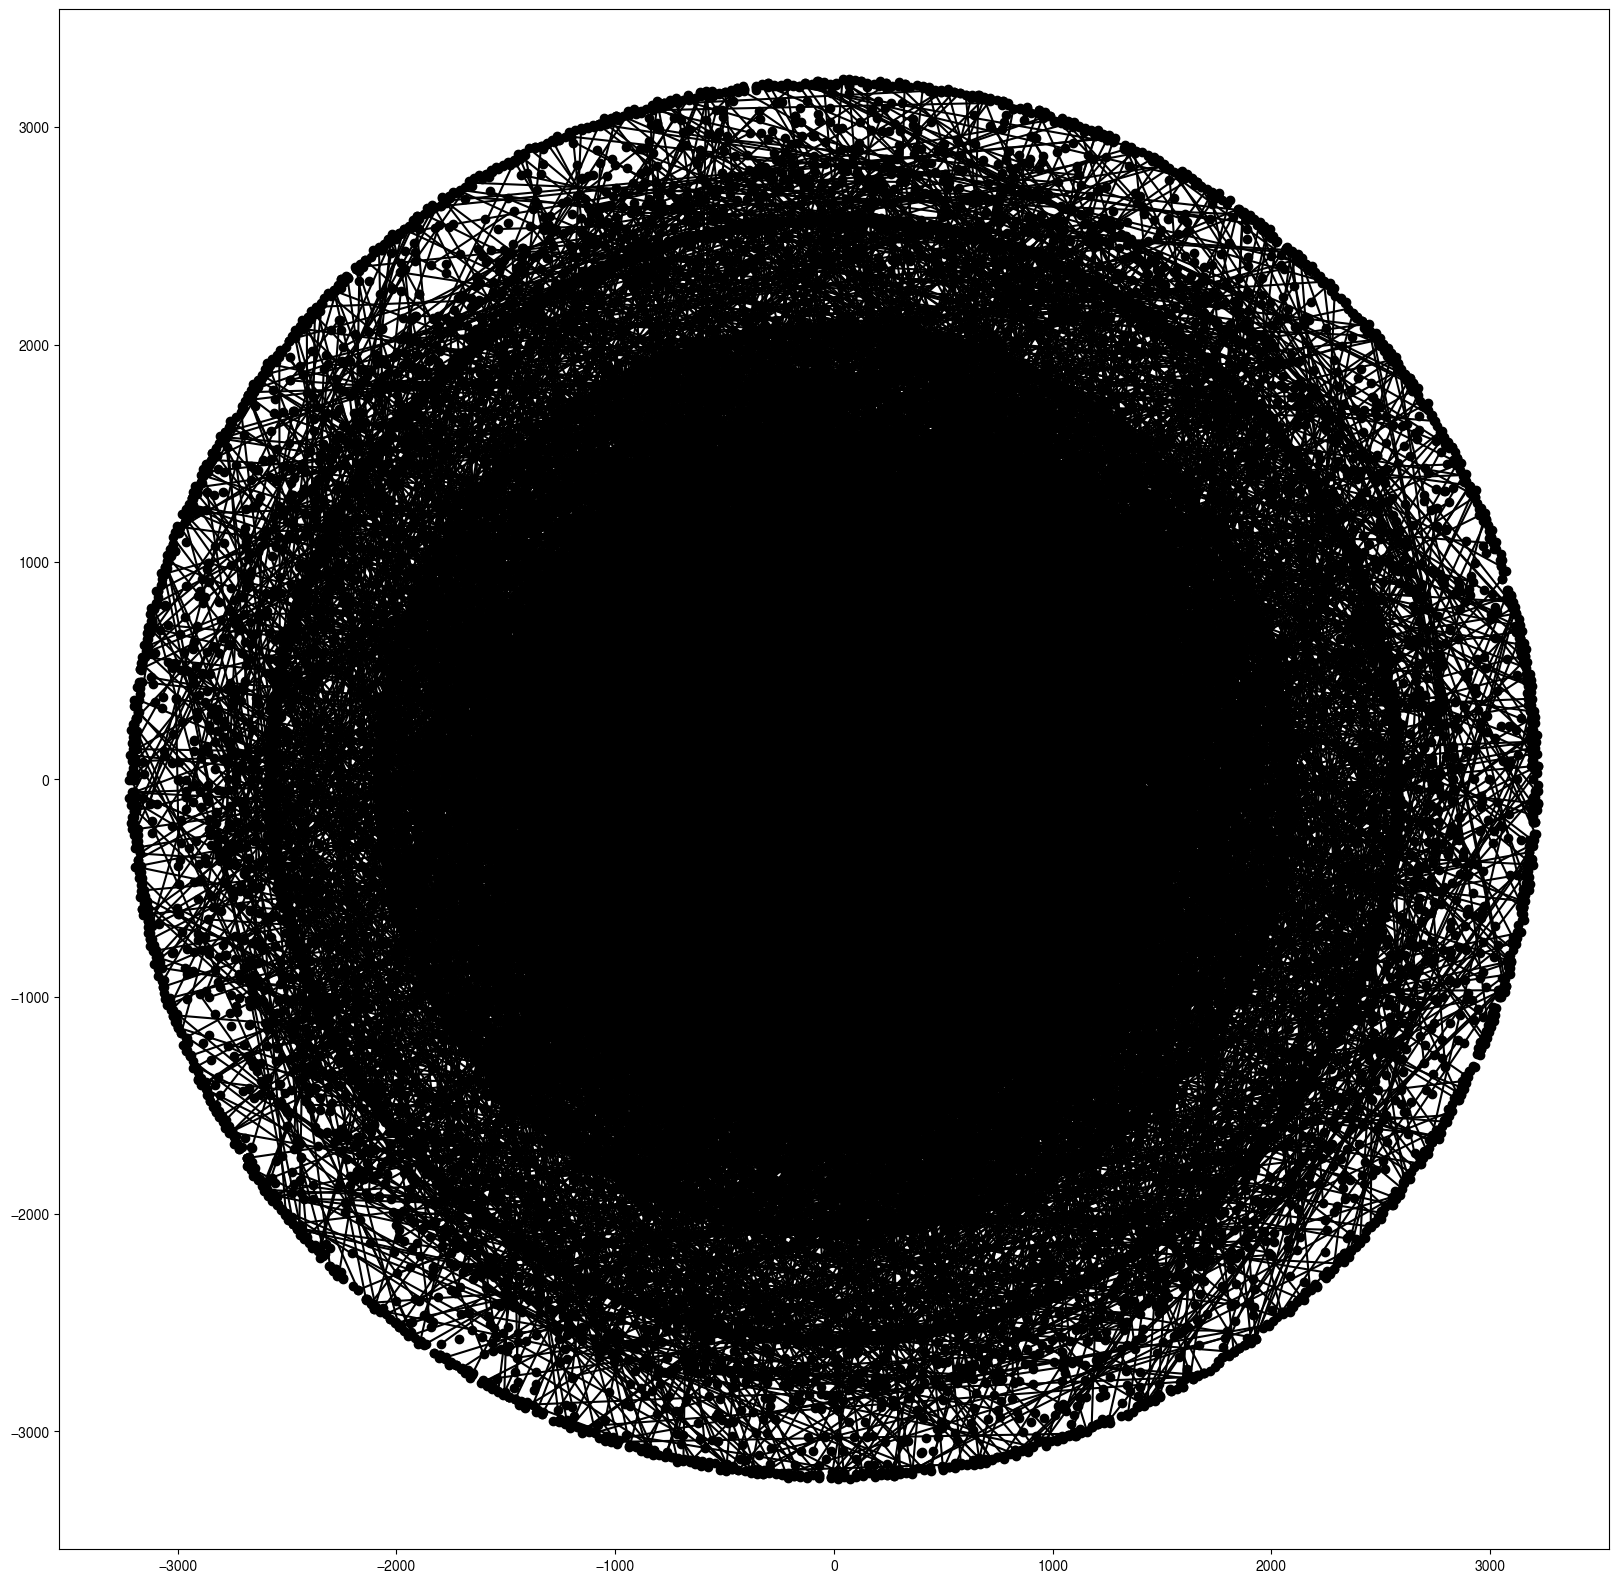

In [18]:
x = model.trainset[0].r*np.cos(model.trainset[0].hit_id)*np.pi*1000.
y = model.trainset[0].r*np.sin(model.trainset[0].hit_id)*np.pi*1000.

plt.figure(figsize=(20,20))
edges = model.trainset[0].edge_index.numpy()
labels = model.trainset[0].y
plt.scatter(x, y, c='k')
preds = model(data).int().detach().numpy()



for j in range(len(labels)):
	alpha_value = max(0, min(1, preds[j]))
	# False negatives
	#if preds[j] < cut and labels[j].item() > cut:
	#	plt.plot([x[edges[0,j]], x[edges[1,j]]],
	#				[y[edges[0,j]], y[edges[1,j]]],
	#				'--', c='b')

	# False positives
	#if preds[j] > cut and labels[j].item() < cut:
	#	plt.plot([x[edges[0,j]], x[edges[1,j]]],
	#				[y[edges[0,j]], y[edges[1,j]]],
	#				'-', c='r', alpha=preds[j])

	# True positives
	if preds[j] > cut and labels[j].item() > cut:
		plt.plot([x[edges[0,j]], x[edges[1,j]]],
					[y[edges[0,j]], y[edges[1,j]]],
					'-', c='k', alpha=alpha_value)
			
	# True negatives
	if preds[j] < cut and labels[j].item() < cut:
		plt.plot([x[edges[0,j]], x[edges[1,j]]],
					[y[edges[0,j]], y[edges[1,j]]],
					'-', c='k', alpha=alpha_value)